To begin with:
1. Since some category is combined with '/' which means there are more than one primary product category. We manually created dummy variables for modeling. For example, if one record has two category, it will show both 1 under the two category column.
2.Tried two modeling methods: 1)Random Forest 2)KNN. Both tried hyperparameter tunning.
3. Fiting two kinds of models is due to fixing the issue of unbalance data. First is to predict whether the source is Costco; Second is to predict which source it is among Walmart, Sams Club, Sears and Target (Without data of Costco).


In [0]:
# Import packages needed
from google.colab import drive
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

# Data Preparation

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
#direct to shared google drive
os.chdir('/content/drive/Shared drives/Capstone - Team 4/FINAL SUBMISSIONS') # Your own path where you save the data
os.listdir()

['Team4_Predictive_Model_Multi-class_Classification.ipynb',
 'Top_Seller_List.xlsx',
 'Team4_Data_For_Predictive_Modeling.xlsx',
 'Team4_Merged_12Amazon_and_Seller-Source_627823_Records.csv',
 'Team4_Searchable_Database.csv',
 'Team4_Search_Tool.ipynb',
 'Team4_Brand_With_Category.csv',
 'Team4_Seller_Locations(State & Country).csv',
 'Team4_Extra_Data_Preprocessing_For_Seller_Level_Modeling.ipynb',
 'Team4_Data Import(12 files) and Match with Seller_Source_4_NoDup.ipynb',
 'Team4_Documentation.gdoc']

In [0]:
# Load data for modeling
df = pd.read_excel('Team4_Data_For_Predictive_Modeling.xlsx')
# Take a look of the original data
df.head()

,Unnamed: 0,Index,Url,Seller_name,Seller_url,Brand_name,Brand_url,listing_count,Marketplace,Sources,Category,Product_names,Brand_average_rating,Number_of_customer_review
0,80000.0,141725,https://www.amazon.com/gp/search/other/ref=sr_...,point and ship,https://www.amazon.com/s/ref=sr_hi_1?me=A3SWC7...,OTC,https://www.amazon.com/s/ref=sr_in_o_p_4_38?me...,3,Amazon.com,walmart,Automative Parts & Accessories,"['OTC 6660 Compression Tester Adapter', 'OTC (...",4.7,25.0
1,80001.0,141726,https://www.amazon.com/gp/search/other/ref=sr_...,point and ship,https://www.amazon.com/s/ref=sr_hi_1?me=A3SWC7...,OTC,https://www.amazon.com/s/ref=sr_in_o_p_4_38?me...,3,Amazon.com,sams club,Automative Parts & Accessories,"['OTC 6660 Compression Tester Adapter', 'OTC (...",4.7,25.0
2,80002.0,154772,https://www.amazon.com/gp/search/other/ref=sr_...,gatzies,https://www.amazon.com/s/ref=sr_hi_1?me=A3TX4Y...,OTC,https://www.amazon.com/s/ref=sr_in_o_p_4_268?m...,1,Amazon.com,costco,Automative Parts & Accessories,['150 Count Multicolored Flexible Plastic Stra...,3.6,5.0
3,80003.0,161321,https://www.amazon.com/gp/search/other/ref=sr_...,bw direct,https://www.amazon.com/s/ref=sr_hi_1?me=A3UKOA...,OTC,https://www.amazon.com/s/ref=sr_in_o_p_4_2?me=...,1,Amazon.com,sears,Automative Parts & Accessories,['OTC 4600 Punch and Chisel Set - 16 Piece'],4.2,47.0
4,80005.0,183139,https://www.amazon.com/gp/search/other/ref=sr_...,isale-usave (usa),https://www.amazon.com/s/ref=sr_hi_1?me=A8JAGP...,OTC,https://www.amazon.com/s/ref=sr_in_o_p_4_8?me=...,2,Amazon.com,costco,Automative Parts & Accessories,['OTC Dancing Monkey: Solar Powered Novelty To...,3.9,190.0


In [0]:
# Select variables for modeling
df = df[['Sources','Category','Brand_average_rating','Number_of_customer_review']]
# For easy aggregation, convert all strings to lower cases
df['Category']=df['Category'].str.lower()

In [0]:
# Since categries are strings, we need to create dummy variables for the categry variable.
# First, look at how many categories there are.
df['Category'].unique()

array(['automative parts & accessories',
       'tools & home improvement / appliance', 'sports & outdoors',
       'health, household & baby care', 'home & kitchen',
       'beauty & personal care', 'pet supplies', 'garden & outdoor',
       'toys & games', 'clothing, shoes & jewelry', 'office product',
       'grocery & gourmet food', 'industrial & scientific', 'electronics',
       'health, household & baby care / beauty & personal care',
       'tools & home improvement', 'baby', 'arts, crafts & sewing',
       'health, household & baby care / industrial & scientific',
       'cell phones & accessories', 'sports & outdoors / toys & games',
       'office product / arts, crafts & sewing',
       'baby / pet supplies / toys & games',
       'sports & outdoors / garden & outdoor',
       'electronics / office product',
       'home & kitchen / industrial & scientific / baby',
       'tools & home improvement / office product',
       'home & kitchen / tools & home improvement',
      

In [0]:
# Define a function to create dummy variables for the category variable
def create_dummy(df):
    # List all categories
    All_category_names = ['clothing, shoes & jewelry','home & kitchen','sports & outdoors','health, household & baby care','tools & home improvement','industrial & scientific','electronics','grocery & gourmet food',
                            'baby','office product','beauty & personal care','pet supplies','garden & outdoor','cell phones & accessories','automative parts & accessories','arts, crafts & sewing','toys & games','appliance']

    # Create columns for dummy variables
    for i in All_category_names:
        df[i] = ''
    # Create dummy variables for category mannully
    for index, row in df.iterrows():
        category = row['Category']
        if '/' in category:
            category = category.split('/')
            category = [x.strip(' ') for x in category]
        else:
            category = [category]
        dummy = [x in category for x in All_category_names]
        dummy_final = list(map(int, dummy))
        # Put it back to the dataframe
        for count, ele in enumerate(All_category_names):
            df[ele][index] = dummy_final[count]
    return df

In [0]:
# Call the function to process the dataframe
create_dummy(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sources,Category,Brand_average_rating,Number_of_customer_review,"clothing, shoes & jewelry",home & kitchen,sports & outdoors,"health, household & baby care",tools & home improvement,industrial & scientific,electronics,grocery & gourmet food,baby,office product,beauty & personal care,pet supplies,garden & outdoor,cell phones & accessories,automative parts & accessories,"arts, crafts & sewing",toys & games,appliance
0,walmart,automative parts & accessories,4.70,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,sams club,automative parts & accessories,4.70,25.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,costco,automative parts & accessories,3.60,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,sears,automative parts & accessories,4.20,47.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,costco,automative parts & accessories,3.90,190.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,costco,toys & games,4.50,4314.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2258,costco,"arts, crafts & sewing",4.45,692.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2259,costco,"arts, crafts & sewing",4.50,32.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2260,walmart,"arts, crafts & sewing",5.00,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [0]:
# Drop the original category variable
df = df.drop(['Category'], axis=1)
# Drop missing value
df=df.dropna()

In [0]:
# Take a look of the target variable to decide how to sample the data
df.groupby(['Sources']).agg({'Sources':'count'})

,Sources
Sources,
amazon.com.indc llc,1
best buy,7
bj's wholesale,4
costco,1584
home depot,1
ingram micro,6
lowes,10
lowes.(canada),1
office depot,1


# Predicting is the source Costco?

### Data Preprocessing

In [0]:
# Copy the original dataframe
df1=df
# Append a new column as dummy variable indicating if this brand sourced from Costco
a=[]
for index, row in df1.iterrows():
  if row['Sources']=='costco':
    a.append(1)
  else:
    a.append(0)
df1['If Costco']=a


# Shuffle data to keep the data random
df1=shuffle(df1)

### Modeling


In [0]:
# Prepare features and target variable
X = df1.iloc[:,1:-2]
y = df1['If Costco']

# Split data to training and validation partitions
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)
print(X_train.shape)
print(X_test.shape)

(1763, 19)
(441, 19)


#### Random Forest Model on **all dataset**

In [0]:
# Fit a random forest model with hyper parameters tuning
rfc = RandomForestClassifier(random_state = 2020, n_jobs=-1, oob_score = True) ## max_features= 'sqrt' ,n_estimators=50
param_grid = { 
    'n_estimators': [800, 850],
    'max_features': ['auto', 'log2'], 
    'class_weight': ['balanced', 'balanced_subsample']
}## max_features: 'sqrt' works the same as 'auto'
#
#
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
RF_model = CV_rfc.fit(X_train, y_train)
print(CV_rfc.best_params_)
y_pred_73 = RF_model.predict(X_test)
print('The Accuracy for test is:', metrics.accuracy_score(y_test, y_pred_73))

{'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 800}
The Accuracy for test is: 0.7074829931972789


##### Confusion Matrix

In [0]:
ConfusionMatrix = confusion_matrix(y_test, y_pred_73)
pd.crosstab(y_test, y_pred_73, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,59,53,112
1,76,253,329
All,135,306,441


In [0]:
np.set_printoptions(precision=2)
ConfusionMatrix = confusion_matrix(y_test, y_pred_73)
cm_normalized = ConfusionMatrix.astype('float')/ConfusionMatrix.sum(axis=1)[:, np.newaxis]
cm_normalized

array([[0.53, 0.47],
       [0.23, 0.77]])

#### Random Forest Model on **part of dataset**
select part of costco data from all, then number of all sources are more balanced

In [0]:
### Select part of the costco data
X = df1.iloc[:,1:-2]
y = df1['If Costco']
costco_index = y.loc[y.values == 1].index
average_num = int((len(y) - len(costco_index))/1)## how many costco data should be used
left_index = random.sample(list(costco_index), average_num)## sample them
y_balanced_costco = y.loc[left_index]
X_balanced_costco = X.loc[left_index]
### Kepp all other sources
not_costco_index = y.loc[y.values == 0].index
y_balanced_not_costco = y.loc[not_costco_index]
X_balanced_not_costco = X.loc[not_costco_index]

### Merge them together for modeling
y_balanced = pd.concat([y_balanced_costco,y_balanced_not_costco])
X_balanced = pd.concat([X_balanced_costco,X_balanced_not_costco])

### Split X and y
y = y_balanced
X = X_balanced

In [0]:
# Fit a random forest model with hyper parameters tuning
rfc = RandomForestClassifier(random_state = 2020, n_jobs=-1, oob_score = True) ## max_features= 'sqrt' ,n_estimators=50
param_grid = { 
    'n_estimators': [800, 850],
    'max_features': ['auto', 'log2'], 
    'class_weight': ['balanced', 'balanced_subsample']
}
## 
## 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
RF_model = CV_rfc.fit(X, y)
print(CV_rfc.best_params_)
y_pred = RF_model.predict(X)
print('The Accuracy for test is:', metrics.accuracy_score(y, y_pred))

{'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 800}
The Accuracy for test is: 0.9129032258064517


##### Confusion Matrix

In [0]:
pd.crosstab(y, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,581,39,620
1,69,551,620
All,650,590,1240


In [0]:
from sklearn.metrics import classification_report as report
print(report(y, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       620
           1       0.93      0.89      0.91       620

    accuracy                           0.91      1240
   macro avg       0.91      0.91      0.91      1240
weighted avg       0.91      0.91      0.91      1240



##### Confusion Matrix in percentage

In [0]:
np.set_printoptions(precision=2)
ConfusionMatrix = confusion_matrix(y, y_pred)
cm_normalized = ConfusionMatrix.astype('float')/ConfusionMatrix.sum(axis=1)[:, np.newaxis]
cm_normalized

array([[0.94, 0.06],
       [0.11, 0.89]])

[0.37 0.38 0.02 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.02 0.01 0.02 0.01
 0.02 0.   0.02 0.   0.02]


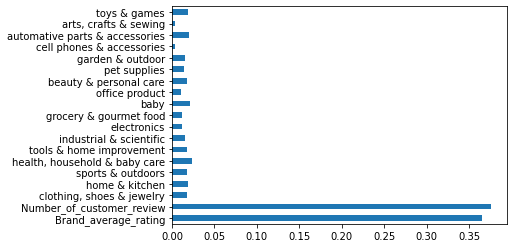

In [0]:
import matplotlib.pyplot as plt
print(RF_model.best_estimator_.feature_importances_) # Use inbuilt class feature_importances of tree based classifiers
# Plot graph of feature importances for better visualization
feat_importances = pd.Series(RF_model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

#### KNN Models

In [0]:
# Try KNN model with hyperparameter tuning

# Creating odd list K for KNN
neighbors = list(range(1,50,2))
# Empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X_train,y_train,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())
# Calculating the misclassificatio error
# Changing to misclassification error
mse = [1-x for x in cv_scores]
# Determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))
# Use the optimal_K fit model
knn_model = KNeighborsClassifier(n_neighbors = optimal_k)
# Fitting model
knn_model.fit(X_train,y_train)
# Predict
KNN_y_test_pred = knn_model.predict(X_test)
print('The Accuracy for test is:', metrics.accuracy_score(y_test,KNN_y_test_pred))

The optimal no. of neighbors is 29
The Accuracy for test is: 0.48936170212765956


# Predicting which source it is among Walmart, Sams Club, Sears and Target (Without data of Costco).

In [0]:
# Copy the original dataframe
df2=df
df_other=df2[df2['Sources'].isin(['walmart','sams club','sears','target'])]
df_other=shuffle(df_other)

In [0]:
df_other

,Sources,Brand_average_rating,Number_of_customer_review,"clothing, shoes & jewelry",home & kitchen,sports & outdoors,"health, household & baby care",tools & home improvement,industrial & scientific,electronics,grocery & gourmet food,baby,office product,beauty & personal care,pet supplies,garden & outdoor,cell phones & accessories,automative parts & accessories,"arts, crafts & sewing",toys & games,appliance,If Costco
652,sears,4.293750,26749.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1030,sears,5.000000,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
990,sears,2.975000,16.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1491,sams club,4.120000,487.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
639,sams club,3.953125,236.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,sears,3.920833,2950.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1363,walmart,4.500000,167.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2056,sams club,3.200000,38.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
978,sears,4.900000,16.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [0]:
# Prepare features and target variable
X = df_other.iloc[:,1:-2]
y = df_other['Sources']

In [0]:
# Fit a random forest model with hyperparameter tuning
# Build a classification task using 3 informative features
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 
param_grid = { 
    'n_estimators': [200, 500, 700, 900],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
RF_model = CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

{'max_features': 'log2', 'n_estimators': 900}


In [0]:
y_pred = RF_model.predict(X)
print('The Accuracy for test is:', metrics.accuracy_score(y, y_pred))

The Accuracy for test is: 0.848381601362862


### Confusion Matrix

In [0]:
ConfusionMatrix = multilabel_confusion_matrix(y, y_pred)
ConfusionMatrix

array([[[414,  48],
        [ 31,  94]],

       [[300,   6],
        [  4, 277]],

       [[547,   0],
        [  5,  35]],

       [[411,  35],
        [ 49,  92]]])

In [0]:
len(y)

587

In [0]:
from collections import defaultdict
count_source = defaultdict(int)
for source in y:
    count_source[source] +=1
count_source

defaultdict(int,
            {'sams club': 125, 'sears': 281, 'target': 40, 'walmart': 141})

In [0]:
sources = ['sams club', 'sears', 'target', 'walmart']

### Confusion Matrix in percentage

In [0]:
np.set_printoptions(precision=2)
for i in range(len(np.unique(y))):
    cm_normalized = ConfusionMatrix[i].astype('float')/ConfusionMatrix[i].sum(axis=1)[:, np.newaxis]
    print(sources[i], "\n", cm_normalized, "\n")

sams club 
 [[0.9  0.1 ]
 [0.25 0.75]] 

sears 
 [[0.98 0.02]
 [0.01 0.99]] 

target 
 [[1.   0.  ]
 [0.12 0.88]] 

walmart 
 [[0.92 0.08]
 [0.35 0.65]] 



[0.33 0.39 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.02 0.02 0.01 0.03 0.01
 0.02 0.01 0.03 0.   0.02]


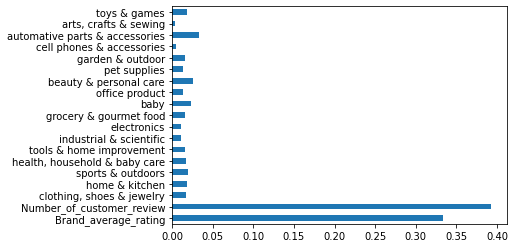

In [0]:
import matplotlib.pyplot as plt
print(RF_model.best_estimator_.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(RF_model.best_estimator_.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh')
plt.show()

In [0]:
# Try KNN model with hyperparameter tuning
# Creating odd list K for KNN
neighbors = list(range(1,50,2))
# empty list that will hold cv scores
cv_scores = [ ]
#perform 10-fold cross-validation
for K in neighbors:
    knn = KNeighborsClassifier(n_neighbors = K)
    scores = cross_val_score(knn,X,y,cv = 10,scoring =
    "accuracy")
    cv_scores.append(scores.mean())
#calculating the misclassificatio error
# Changing to mis classification error
mse = [1-x for x in cv_scores]
# determing best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal no. of neighbors is {}".format(optimal_k))
#use the optimal_K fit model
knn_model = KNeighborsClassifier(n_neighbors = optimal_k)
# fitting model
knn_model.fit(X,y)
#predict
KNN_y = knn_model.predict(X)
print('The Accuracy for test is:', metrics.accuracy_score(y,KNN_y))

The optimal no. of neighbors is 1
The Accuracy for test is: 0.848381601362862


# Predicting which source it is among Costco, Walmart, Sams Club, Sears and Target 

### Data Split

In [0]:
y = df['If Costco']
costco_index = y.loc[y.values == 1].index
average_num = (len(y) - len(costco_index))//4## how many costco data should be used
left_index = random.sample(list(costco_index), average_num)## sample them

df_costco = df.loc[left_index]
df_other=df[df['Sources'].isin(['walmart','sams club','sears','target'])]
df2 = shuffle(pd.concat([df_costco, df_other])).iloc[:,:-2]
df2.head()

,Sources,Brand_average_rating,Number_of_customer_review,"clothing, shoes & jewelry",home & kitchen,sports & outdoors,"health, household & baby care",tools & home improvement,industrial & scientific,electronics,grocery & gourmet food,baby,office product,beauty & personal care,pet supplies,garden & outdoor,cell phones & accessories,automative parts & accessories,"arts, crafts & sewing",toys & games
2089,sears,4.2,202.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
824,sears,4.6,36.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2085,sams club,4.3,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
303,costco,4.0,310.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1672,sears,4.3,3706.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Random Forest Model

In [0]:
# Prepare features and target variable
X = df2.iloc[:,1:]
y = df2['Sources']

# Fit a random forest model with hyper parameters tuning
rfc = RandomForestClassifier(random_state = 2020, n_jobs=-1, oob_score = True) ## max_features= 'sqrt' ,n_estimators=50
param_grid = { 
    'n_estimators': [800, 850, 900, 920],
    'max_features': ['auto', 'log2'], 
    'class_weight': ['balanced', 'balanced_subsample']
}
## max_features: 'sqrt' works the same as 'auto'
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
RF_model = CV_rfc.fit(X, y)
print(CV_rfc.best_params_)
y_pred = RF_model.predict(X)
print('The Accuracy for test is:', metrics.accuracy_score(y, y_pred))

{'class_weight': 'balanced', 'max_features': 'auto', 'n_estimators': 800}
The Accuracy for test is: 0.8477088948787062


In [0]:
ConfusionMatrix = multilabel_confusion_matrix(y, y_pred)
ConfusionMatrix

array([[[577,  10],
        [ 15, 140]],

       [[538,  79],
        [  6, 119]],

       [[457,   4],
        [ 15, 266]],

       [[687,  15],
        [  0,  40]],

       [[596,   5],
        [ 77,  64]]])

#### Confusion Matrix in percentage

In [0]:
from collections import defaultdict
source = defaultdict(int)
for i in y:
    source[i]+=1
source

defaultdict(int,
            {'costco': 155,
             'sams club': 125,
             'sears': 281,
             'target': 40,
             'walmart': 141})

In [0]:
sources = ['Costco', 'Sam\'s Club', 'Sears', 'Target', 'Walmart']

In [0]:
np.set_printoptions(precision=2)
for i in range(df2.Sources.nunique()):
    cm_normalized = ConfusionMatrix[i].astype('float')/ConfusionMatrix[i].sum(axis=1)[:, np.newaxis]
    print(sources[i], "\n", cm_normalized)

Costco 
 [[0.98 0.02]
 [0.1  0.9 ]]
Sam's Club 
 [[0.87 0.13]
 [0.05 0.95]]
Sears 
 [[0.99 0.01]
 [0.05 0.95]]
Target 
 [[0.98 0.02]
 [0.   1.  ]]
Walmart 
 [[0.99 0.01]
 [0.55 0.45]]
